In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division

import numpy as np
import glob, os, sys, pickle, json

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils

import enterprise_extensions as e_e
from enterprise_extensions import sampler
from enterprise_extensions.sampler import JumpProposal

"""
import arviz as az
import warnings
warnings.filterwarnings('ignore')

import enterprise_extensions
from enterprise_extensions import models, model_utils, timing
from enterprise_extensions import sampler as ee_sampler
"""
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import la_forge.diagnostics as dg
import la_forge.core as co
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import andrew_utils as au

In [4]:
psrlist = ["J1744-1134"]
datarelease = '5yr'
tm_prior = "uniform"
ephem = 'DE436'
white_var = True
red_var = True

run_num = 1
resume = False
N = int(1e4)

coefficients = False
tm_var=True
nltm_plus_ltm = False
exclude = True
tm_linear=True

writeHotChains = False
reallyHotChain = False

In [5]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])
"""
e_e_path = top_dir + "/enterprise_extensions/"
noise_path = top_dir + "/pta_sim/pta_sim"
sys.path.insert(0, noise_path)
sys.path.insert(0, e_e_path)
import enterprise_extensions as e_e
from enterprise_extensions import sampler
from enterprise_extensions import models_2 as models
from enterprise_extensions.sampler import JumpProposal
import noise

"""
datadir = top_dir + "/{}".format(datarelease)

parfiles = sorted(glob.glob(datadir + "/par/*.par"))
timfiles = sorted(glob.glob(datadir + "/tim/*.tim"))
# filter
parfiles = [
    x for x in parfiles if x.split("/")[-1].split(".")[0].split("_")[0] in psrlist
]
timfiles = [
    x for x in timfiles if x.split("/")[-1].split(".")[0].split("_")[0] in psrlist
]

In [6]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephem, clk=None, drop_t2pulsar=False)
    psrs.append(psr)

In [7]:
noisedict = {}
if datarelease in ['12p5yr']:
    noisefiles = sorted(glob.glob(top_dir + '/{}/*.json'.format(datarelease)))
    for noisefile in noisefiles:
        tmpnoisedict = {}
        with open(noisefile, 'r') as fin:
            tmpnoisedict.update(json.load(fin))
        for key in tmpnoisedict.keys():
            if key.split('_')[0] in psrlist:
                noisedict[key] = tmpnoisedict[key]
else:
    noisefiles = sorted(glob.glob(datadir + "/noisefiles/*.txt"))
    for noisefile in noisefiles:
        tmpnoisedict = {}
        tmpnoisedict = au.get_noise_from_file(noisefile)
        for og_key in tmpnoisedict.keys():
            split_key = og_key.split('_')
            psr_name = split_key[0]
            if psr_name in psrlist:
                if datarelease in ['5yr']:
                    param = "_".join(split_key[1:])
                    new_key = "_".join([psr_name,"_".join(param.split("-"))])
                    noisedict[new_key] = tmpnoisedict[og_key]
                else:
                    noisedict[og_key] = tmpnoisedict[og_key]

In [8]:
if nltm_plus_ltm:
    outdir = current_path + "/chains/{}/".format(datarelease) + psrlist[0] +\
     "_{}_{}_nltm_ltm_{}".format("_".join(tm_prior.split('-')),ephem,run_num)
else:
    outdir = current_path + "/chains/{}/".format(datarelease) + psrlist[0] +\
    "_{}_{}_tm_{}".format("_".join(tm_prior.split('-')),ephem,run_num)

#if os.path.isdir(outdir) and not resume:
#    raise ValueError('{} already exists!'.format(outdir))

In [9]:
tm_params_nodmx = []
ltm_exclude_list=[]
for psr in psrs:
    for par in psr.fitpars:
        if "DMX" in ["".join(list(x)[0:3]) for x in par.split("_")][0]:
            pass
        elif "FD" in ["".join(list(x)[0:2]) for x in par.split("_")][0]:
            pass
        elif "JUMP" in ["".join(list(x)[0:4]) for x in par.split("_")][0]:
            pass
        elif par in ["Offset","TASC"]:
            pass
        elif par in ["RAJ", "DECJ", "ELONG", "ELAT", "BETA", "LAMBDA"]:
            ltm_exclude_list.append(par)
        elif par in ["F0"]:
            ltm_exclude_list.append(par)
        #elif par in ["PMRA", "PMDEC", "PMELONG", "PMELAT", "PMBETA", "PMLAMBDA"]:
        #    pass
        else:
            tm_params_nodmx.append(par)

tm_param_list = tm_params_nodmx
if not tm_linear and tm_var:
    print("Non-linearly varying these values: ", tm_param_list, "\n in pulsar ", psrlist[0])
elif tm_linear and tm_var:
    print("Using linear approximation for all timing parameters.")
else:
    print('Not varying timing parameters.')

if nltm_plus_ltm:
    if exclude:
        ltm_exclude_list=tm_param_list
        print("Linearly varying everything but these values: ", ltm_exclude_list, "\n in pulsar ", psrlist[0])
    else:
        print("Linearly varying only these values: ", ltm_exclude_list, "\n in pulsar ", psrlist[0])

print("Using ",tm_prior," prior.")

Using linear approximation for all timing parameters.
Using  uniform  prior.


In [10]:
pta = au.model_nltm(
    psrs,
    tm_var=tm_var,
    tm_linear=tm_linear,
    tm_param_list=tm_param_list,
    ltm_exclude_list=ltm_exclude_list,
    exclude = exclude,
    tm_param_dict={},
    tm_prior=tm_prior,
    nltm_plus_ltm = nltm_plus_ltm,
    common_psd="powerlaw",
    red_psd="powerlaw",
    orf=None,
    common_var=False,
    common_components=30,
    red_components=30,
    dm_components=30,
    modes=None,
    wgts=None,
    logfreq=False,
    nmodes_log=10,
    noisedict=noisedict,
    tm_svd=False,
    tm_norm=True,
    gamma_common=None,
    upper_limit=False,
    upper_limit_red=None,
    upper_limit_dm=None,
    upper_limit_common=None,
    bayesephem=False,
    be_type="orbel",
    wideband=False,
    dm_var=False,
    dm_type="gp",
    dm_psd="powerlaw",
    dm_annual=False,
    white_vary=white_var,
    gequad=False,
    dm_chrom=False,
    dmchrom_psd="powerlaw",
    dmchrom_idx=4,
    red_var=red_var,
    red_select=None,
    red_breakflat=False,
    red_breakflat_fq=None,
    coefficients=coefficients,
)

In [11]:
# dimension of parameter space
params = pta.param_names
ndim = len(params)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1 ** 2)

In [12]:
# parameter groupings
groups = sampler.get_parameter_groups(pta)
tm_groups = au.get_timing_groups(pta)
for tm_group in tm_groups:
    groups.append(tm_group)

wn_pars = ['ecorr','equad','efac']
groups.append(sampler.group_from_params(pta, wn_pars))

In [13]:
psampler = ptmcmc(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    groups=groups,
    outDir=outdir,
    resume=resume,
)

In [14]:
np.savetxt(outdir + "/pars.txt", list(map(str, pta.param_names)), fmt="%s")
np.savetxt(
    outdir + "/priors.txt",
    list(map(lambda x: str(x.__repr__()), pta.params)),
    fmt="%s",
)

In [15]:
if tm_var and not tm_linear:
    jp = JumpProposal(pta)
    psampler.addProposalToCycle(jp.draw_from_signal("non_linear_timing_model"), 30)
    for p in pta.params:
        for cat in ["pos", "pm", "spin", "kep", "gr"]:
            if cat in p.name.split("_"):
                psampler.addProposalToCycle(jp.draw_from_par_prior(p.name), 30)

In [16]:
tmp = True
#if coefficients:
"""if tmp:
    x0_dict = {}
    cpar = []
    for p in pta.params:
        print(p)
        if "coefficients" in p.name:
            cpar.append(p)
        else:
            x0_dict.update({p.name:p.sample()})

    pr2 = cpar[0].get_logpdf(params=x0_dict)
    print(pr2)
    psc = utils.get_coefficients(pta, x0_dict)
    print(psc)"""
if coefficients:
    x0_list = []
    for p in pta.params:
        if "coefficients" not in p.name:
            x0_list.append(p.sample())
    x0 = np.asarray(x0_list)
else:
    x0 = np.hstack([p.sample() for p in pta.params])

In [17]:
psampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50,
    writeHotChains=writeHotChains,hotChain=reallyHotChain)

/home/andrew/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 90.00 percent in 109.196955 s Acceptance rate = 0.24757
Run Complete


In [18]:
core=co.Core(label=outdir.split('/')[-1], chaindir=outdir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 225
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


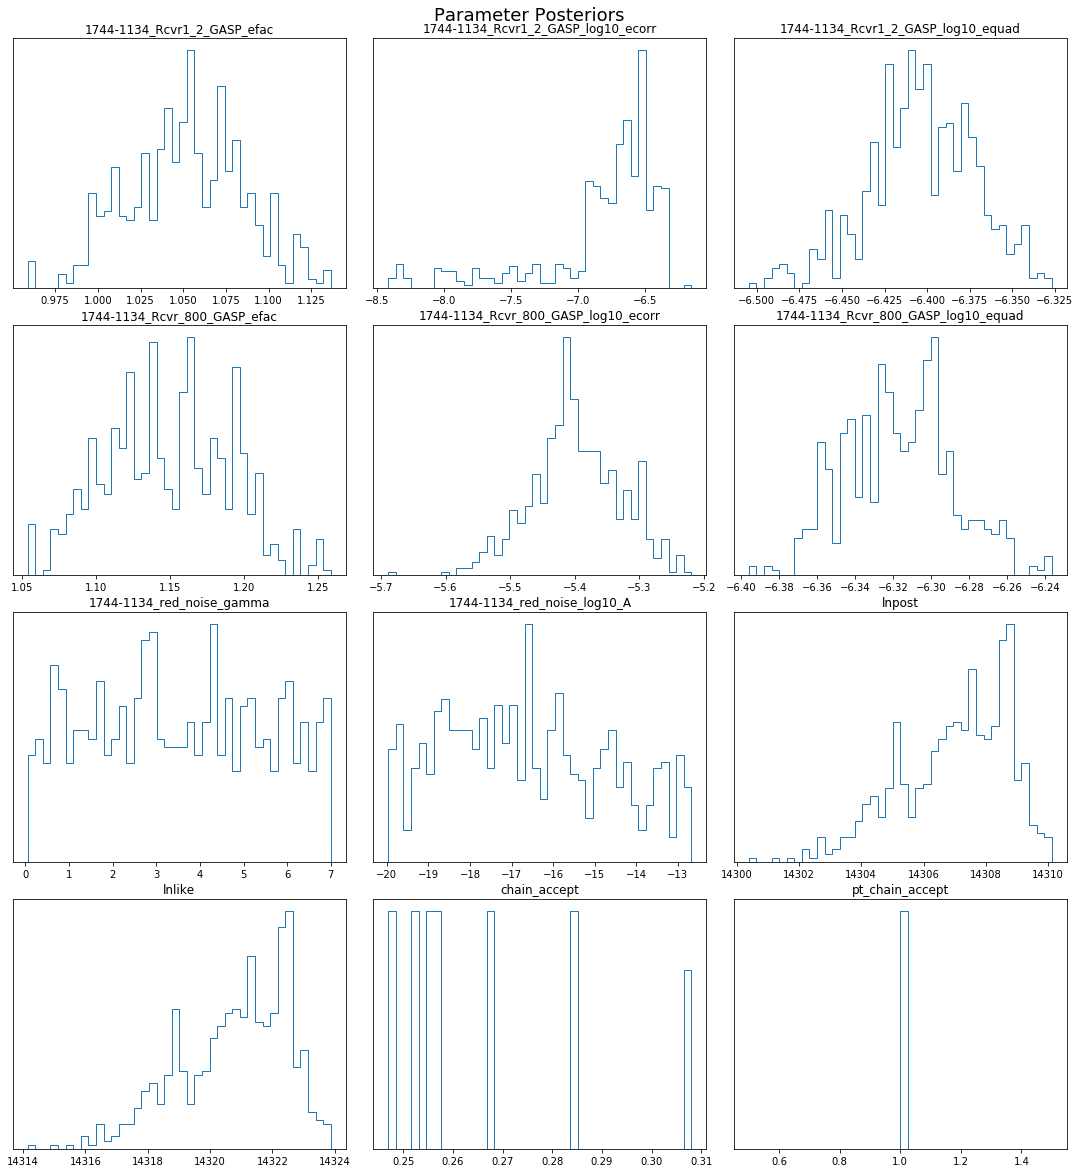

In [19]:
dg.plot_chains(core)